In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style('darkgrid')

In [3]:
df = pd.read_csv('laptops.csv')

In [4]:
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

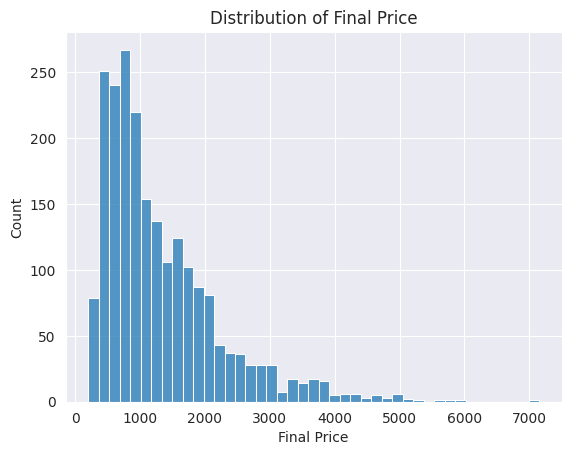

In [6]:
sns.histplot(data=df, x='final_price')
plt.xlabel('Final Price')
plt.title('Distribution of Final Price');

In [7]:
df.isna().sum()

laptop             0
status             0
brand              0
model              0
cpu                0
ram                0
storage            0
storage_type      42
gpu             1371
screen             4
touch              0
final_price        0
dtype: int64

In [8]:
round(df.isna().sum()/len(df), 4)

laptop          0.0000
status          0.0000
brand           0.0000
model           0.0000
cpu             0.0000
ram             0.0000
storage         0.0000
storage_type    0.0194
gpu             0.6347
screen          0.0019
touch           0.0000
final_price     0.0000
dtype: float64

In [9]:
df.ram.median()

np.float64(16.0)

In [10]:
df.ram.value_counts()

ram
16     928
8      817
32     301
4       68
64      25
12      15
6        3
40       2
128      1
Name: count, dtype: int64

In [11]:
# create a random seed
np.random.seed(42)

# get the length of the dataframe
n = len(df)


n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

# randomize the dataframe
df_shuffled = df.iloc[idx]

# split into 60/20/20
df_test = df_shuffled.iloc[n_train+n_val:].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_train = df_shuffled.iloc[:n_train].copy()

In [12]:
# test the data split
df_dict = {
    "df_test": df_test,
    "df_val": df_val,
    "df_train": df_train
}

# get the total length
total_length = sum(len(df) for df in df_dict.values())

# print the ratio of each dataframe's length to the total length
for name, df in df_dict.items():
    print(f"{name}: {int((len(df) / total_length) * 100)}%")


df_test: 20%
df_val: 20%
df_train: 60%


In [13]:
df_train.final_price.values

array([1123.29,  201.05,  997.74, ..., 1059.  , 1671.  , 1056.  ])

In [14]:
np.log1p(df_train.final_price.values)

array([7.024907  , 5.30851519, 6.90649448, ..., 6.96602419, 7.42177579,
       6.96318999])

In [15]:
y_train_orig = df_train.final_price.values
y_val_orig = df_val.final_price.values
y_test_orig = df_test.final_price.values

y_train = np.log1p(df_train.final_price.values)
y_val = np.log1p(df_val.final_price.values)
y_test = np.log1p(df_test.final_price.values)

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [16]:
y_train

array([7.024907  , 5.30851519, 6.90649448, ..., 6.96602419, 7.42177579,
       6.96318999])

In [17]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [18]:
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch'],
      dtype='object')

In [19]:
# extract the base variables
base = ['ram', 'storage', 'screen']

In [20]:
# extract the categorical variables
categorical_variables = [
    'status', 'brand', 'model', 'cpu', 'storage_type', 'gpu', 'touch'
]

categories = {}

for c in categorical_variables:
    categories[c] = list(df[c].value_counts().head().index)

In [21]:
categories

{'status': ['New', 'Refurbished'],
 'brand': ['Asus', 'Lenovo', 'HP', 'MSI', 'Acer'],
 'model': ['VivoBook', 'ThinkPad', 'ROG', '15S', 'IdeaPad'],
 'cpu': ['Intel Core i7',
  'Intel Core i5',
  'AMD Ryzen 7',
  'AMD Ryzen 5',
  'Intel Core i3'],
 'storage_type': ['SSD', 'eMMC'],
 'gpu': ['RTX 3050', 'RTX 3060', 'RTX 3070', 'RTX 4060', 'RTX 3080'],
 'touch': ['No', 'Yes']}

In [22]:
def prepare_X(df, fill_value=0):
    df = df.copy()
    features = base.copy()
   
    for c, values in categories.items():
        for v in values:
            df['%s_%s' % (c, v)] = (df[c] == v).astype('int')
            features.append('%s_%s' % (c,v))

    df_num = df[features].copy()
    df_num['screen'] = df_num['screen'].fillna(fill_value)
    X = df_num.values

    return X

In [23]:
# prepare_X(df_test, fill_value=df['screen'].mean())

In [24]:
# define rmse
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

### Question 3

In [25]:
# train and validate with 0
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('RMSE with fill_0:', rmse(y_val, y_pred))

RMSE with fill_0: 13.931420489710344


In [26]:
# train and validate with mean
X_train = prepare_X(df_train, fill_value=df['screen'].mean())
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('RMSE with fill_mean:', rmse(y_val, y_pred))

RMSE with fill_mean: 5.83115290409171


In [27]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [28]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print(f"{'%2s' %r} r gives RMSE of {round(rmse(y_val, y_pred),2)}")

 0 r gives RMSE of 13.93
0.01 r gives RMSE of 0.35
0.1 r gives RMSE of 0.35
 1 r gives RMSE of 0.35
 5 r gives RMSE of 0.37
10 r gives RMSE of 0.4
100 r gives RMSE of 0.58


### Question 5

In [29]:
df = pd.read_csv('laptops.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [30]:

def random_test_validate(seed_no):
    np.random.seed(seed_no)

    # get the length of the dataframe
    n = len(df)


    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    # randomize the dataframe
    df_shuffled = df.iloc[idx]

    # split into 60/20/20
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_train = df_shuffled.iloc[:n_train].copy()


    y_train = np.log1p(df_train.final_price.values)
    y_val = np.log1p(df_val.final_price.values)
    y_test = np.log1p(df_test.final_price.values)

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    return df_test, df_val, df_train, y_train , y_val, y_test

In [31]:
list_of_seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

rmse_list = []

for seed_no in list_of_seeds:
    df_test, df_val, df_train, y_train , y_val, y_test = random_test_validate(seed_no)
    X_train = prepare_X(df_train)
    w_0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val)
    y_pred = w_0 + X_val.dot(w)

    rmse_val = rmse(y_val, y_pred)

    print(f"RMSE with seed {seed_no}: {rmse_val}")
    rmse_list.append(rmse_val)



RMSE with seed 0: 36.96067021088223
RMSE with seed 1: 6.483187072846573
RMSE with seed 2: 10.050542269012057
RMSE with seed 3: 7.430433823394486
RMSE with seed 4: 63.81768218369093
RMSE with seed 5: 8.897804765913083
RMSE with seed 6: 7.8902311394023465
RMSE with seed 7: 11.5658256814283
RMSE with seed 8: 8.629952574478184
RMSE with seed 9: 93.67814831106472


In [32]:
rmse_std = round(np.std(rmse_list), 3)
rmse_std

np.float64(28.704)

### Question 6

In [38]:
df = pd.read_csv('laptops.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [46]:
np.random.seed(9)

# get the length of the dataframe
n = len(df)


n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

# randomize the dataframe
df_shuffled = df.iloc[idx]

# split into 60/20/20
df_test = df_shuffled.iloc[n_train+n_val:].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_train = df_shuffled.iloc[:n_train].copy()

df_train_main = pd.concat([df_train, df_val], ignore_index=True)

y_train = np.log1p(df_train_main.final_price.values)
y_test = np.log1p(df_test.final_price.values)

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [48]:
X_train = prepare_X(df_train_main)
X_test = prepare_X(df_test)

w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
y_pred = w_0 + X_test.dot(w)
print(rmse(y_test, y_pred))

0.371897707870524
